<a href="https://colab.research.google.com/github/spdkh/Leaf-Classification/blob/main/spjc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Leaf Classification Project

It is impossible to overestimate the significance of plant identification in industries like medicine, botany, and the food business. The identification of a plant's species relies heavily on its leaves, however this can be challenging if the leaves have a complicated backdrop that causes interferences and overlaps. This paper evaluates three machine learning techniques for identifying leaf photos in order to solve this issue. The suggested strategy entails first collecting morphological and texture information from the area of interest, then using classification techniques to identify leaves. According to the testing findings, this method reaches a peak accuracy of 75%. This method, which is crucial in many sectors, can considerably improve automated systems for plant identification.

More information found in the google document below: 
https://docs.google.com/document/d/1Fo0gS5RvHTSdCsmYdcrwn2UbKiE52q3Y2axMukNq7nU/edit?usp=sharing

# Load Packages

In [ ]:
import os
import time
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from tensorflow import keras

from skimage.measure import regionprops_table
from skimage.morphology import binary_closing, label
from skimage.measure import regionprops
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from skimage.transform import resize

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm


# Function Definition

In [ ]:
def segment_leaf(grayscale_image):
    """
        Leaf Segmentation
    """
    # Apply Otsu's method to binarize the image
    thr_leaf = threshold_otsu(grayscale_image) + 0.05
    # print(thr_leaf)
    thr_shadow = thr_leaf / 4

    binary_image = grayscale_image.copy()
    binary_image[binary_image < thr_shadow] = 1
    binary_image = binary_image > thr_leaf

    # Apply a morphological closing operation to clean the image
    clean_image = binary_closing(binary_image)

    # Convert the cleaned image to an integer data type
    clean_image = clean_image.astype(np.uint8)

    return clean_image


def plot_random(input_imgs, y, cols, rows=1, cmap='gray'):
    # creates a figure with subplots organized in a grid pattern with the specified number of rows and columns.
    fig,ax = plt.subplots(nrows=rows, ncols=cols,
                        figsize=(20,6),
                        subplot_kw=dict(xticks=[], yticks=[]))


    # iterate over each row and column in the grid and display an image
    # The images to be displayed are accessed from the variable x

    for row in range(rows): 
        for col in range(cols):
            rand_sample = np.random.choice(np.shape(input_imgs)[0])
            ax[row, col].imshow(input_imgs[rand_sample], cmap=cmap) 

            # The title for each image is accessed from the variable y, 
            # which is a list of class IDs that correspond to each image in x
            title = plant_types[class_ids.index(y[rand_sample])]
            ax[row, col].set_title(title)
            
    # show the figure
    plt.show()

# Download the PlantVillage dataset

In [ ]:
!git clone https://github.com/spMohanty/PlantVillage-Dataset
!cd PlantVillage-Dataset

Cloning into 'PlantVillage-Dataset'...
remote: Enumerating objects: 163229, done.
remote: Total 163229 (delta 0), reused 0 (delta 0), pack-reused 163229
Receiving objects: 100% (163229/163229), 2.00 GiB | 27.71 MiB/s, done.
Resolving deltas: 100% (99/99), done.
Updating files: 100% (182401/182401), done.


# Data Pre-Processing: 
## Collect the list of the plants


In [ ]:
# the path to the directory containing the plant image data.
raw_path = 'PlantVillage-Dataset/raw/color/' 

# Lists all the files and directories in the specified directory (raw_path)
# Including subdirectories and hidden files.
all_categories = os.listdir(raw_path)

# A list comprehension that extracts the unique plant types from the image file names
plant_types = list(set([path.split('_')[0].split(',')[0] for path in os.listdir(raw_path)]))
print(all_categories)
plant_types.sort()
print(plant_types)

['Raspberry___healthy', 'Potato___Late_blight', 'Strawberry___healthy', 'Cherry_(including_sour)___healthy', 'Tomato___healthy', 'Tomato___Tomato_mosaic_virus', 'Tomato___Leaf_Mold', 'Pepper,_bell___Bacterial_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Grape___Esca_(Black_Measles)', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Peach___healthy', 'Apple___healthy', 'Tomato___Target_Spot', 'Tomato___Early_blight', 'Peach___Bacterial_spot', 'Orange___Haunglongbing_(Citrus_greening)', 'Apple___Cedar_apple_rust', 'Apple___Black_rot', 'Grape___Black_rot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Soybean___healthy', 'Potato___healthy', 'Corn_(maize)___healthy', 'Squash___Powdery_mildew', 'Corn_(maize)___Common_rust_', 'Strawberry___Leaf_scorch', 'Tomato___Late_blight', 'Tomato___Septoria_leaf_spot', 'Cherry_(including_sour)___Powdery_mildew', 'Blueberry___healthy', 'Potato___E

## Preparing a dataset of plant images for a machine learning task

In [ ]:
# select number of plant types
n_classes = 10

# converts a list of plant types into one-hot encoded labels
class_ids = keras.utils.to_categorical(range(len(plant_types[:n_classes + 1]))).tolist()


# empty lists that will be filled with the file paths and corresponding labels for each image.
x_paths = []
y = []


#  loops through each plant type
for i, plant_type in enumerate(plant_types[:n_classes + 1]):
    print(plant_type)

    # find all image file paths that match a certain pattern. These image paths are stored in plant_dirs.
    # plant_dirs = glob.glob(raw_path + r'*' + plant_type + r'*/*', recursive=True)
    plant_dirs = glob.glob(raw_path + plant_type + '___healthy' + r'/*', recursive=True)
    #   add the current image file paths and corresponding labels to x_paths and y, respectively
    x_paths.extend(plant_dirs)
    y.extend([class_ids[i]] * len(plant_dirs))

    # The shape of y is printed to the console for debugging purposes.
    print(np.shape(y))
    

Apple
(1645, 11)
Blueberry
(3147, 11)
Cherry
(3147, 11)
Corn
(3147, 11)
Grape
(3570, 11)
Orange
(3570, 11)
Peach
(3930, 11)
Pepper
(3930, 11)
Potato
(4082, 11)
Raspberry
(4453, 11)
Soybean
(9543, 11)


In [ ]:

# loads each image from its file path
x = [segment_leaf(rgb2gray(plt.imread(x_path))) for x_path in x_paths]
X_processed = [resize(img, (32, 32)).ravel() for img in x]

# a pandas DataFrame is created with columns for the image file paths, labels, and image data
df = pd.DataFrame(x_paths, columns=['image name'])
df['target'] = y
df['image'] = x

df

,image name,target,image
0,PlantVillage-Dataset/raw/color/Apple___healthy...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
1,PlantVillage-Dataset/raw/color/Apple___healthy...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,PlantVillage-Dataset/raw/color/Apple___healthy...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,PlantVillage-Dataset/raw/color/Apple___healthy...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,PlantVillage-Dataset/raw/color/Apple___healthy...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,..."
...,...,...,...
9538,PlantVillage-Dataset/raw/color/Soybean___healt...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
9539,PlantVillage-Dataset/raw/color/Soybean___healt...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
9540,PlantVillage-Dataset/raw/color/Soybean___healt...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
9541,PlantVillage-Dataset/raw/color/Soybean___healt...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


## Display a grid of images with their corresponding titles

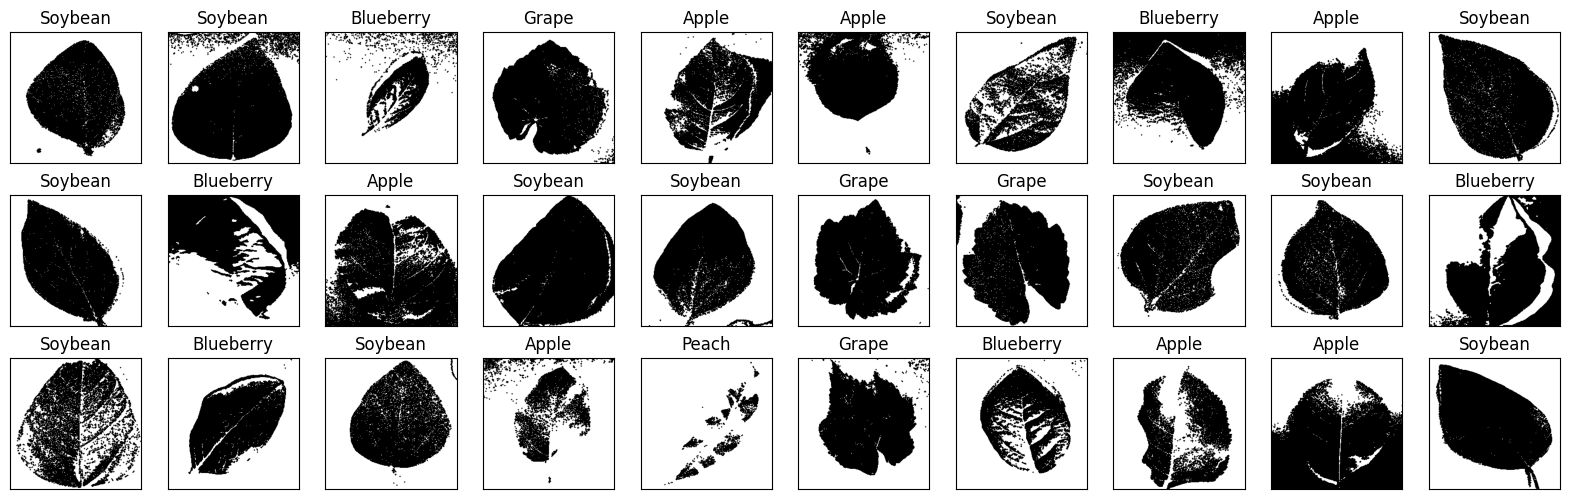

In [ ]:
# 'img_per_row and img_per_col are variables used to determine the number of images to be displayed in each row and column.
img_per_row = 10
img_per_col = 3

plot_random(x, y, img_per_row, img_per_col)

## Train-Test Split

In [ ]:
# Preprocess the images
np.random.seed(0)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2)

print('X train size', np.shape(X_train))
print('X test size', np.shape(X_test))
print('y train size', np.shape(y_train))
print('y test size', np.shape(y_test))

X train size (7634, 1024)
X test size (1909, 1024)
y train size (7634, 11)
y test size (1909, 11)


# Classification

Logistic Regression, MLP (Multilayer Perceptron), and Random Forest are all powerful machine learning algorithms that can be used for image classification tasks.

Logistic Regression is a simple yet effective algorithm that can be used for binary classification problems. However, it can also be extended to multiclass classification tasks using a one-vs-rest approach. Logistic Regression is particularly useful for problems where the classes are linearly separable. It is also computationally efficient and can handle large datasets with ease.

MLP, on the other hand, is a type of neural network that can be used for both binary and multiclass classification problems. It is a powerful algorithm that can learn complex patterns in the data and can perform well on a wide range of problems. MLP is also highly flexible and can be customized by changing the number of layers, nodes, activation functions, etc.

Random Forest is an ensemble algorithm that can be used for classification and regression problems. It works by building multiple decision trees on random subsets of the data and then combining their outputs to make the final prediction. Random Forest is particularly useful for problems where the data has a high degree of noise or where there are many irrelevant features. It can also handle missing data and can provide estimates of feature importance.

When it comes to image classification, these algorithms can be used to extract features from the images and classify them into different classes. Logistic Regression and MLP can be used as classifiers on the extracted features, while Random Forest can be used to directly classify the images by building decision trees on the image features.

In summary, Logistic Regression, MLP, and Random Forest are all effective algorithms for image classification tasks, and the specific choice of algorithm would depend on the characteristics of the dataset and the performance requirements of the task at hand.

## Multilayer Perceptron

In [ ]:
# Train MLP
mlp_model = MLPClassifier(hidden_layer_sizes=(150,),
                    max_iter=250,
                    early_stopping=True,
                    n_iter_no_change=50,
                    learning_rate='adaptive',
                    learning_rate_init=0.05, 
                    random_state=0, 
                    tol=1e-4)
t = time.time()
mlp_trained = mlp_model.fit(X_train, y_train)
print('Training Time:', time.time() - t)
mlp_score = mlp_model.score(X_test, y_test)


Training Time: 88.7397780418396
Training Time: 64.99607706069946


Best Validation Score: 0.7630890052356021


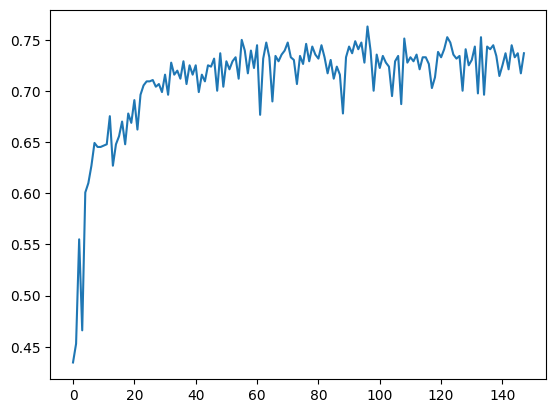

In [ ]:
plt.plot(mlp_model.validation_scores_)
print('Best Validation Score:', mlp_model.best_validation_score_)

## Random Forest

In random forest algorithm, number of estimators, the parameter represents the number of decision trees in the forest, is set to 100. Increasing this value may lead to better performance, but it will also increase the time required for training. The criterion is set to Gini impurity. The maximum depth of each decision tree is not specified so that the nodes are expanded until all the leaves are pure or until all the leaves contain the minimum number of samples required to split an internal node, which is set to 2. The samples are regularized using bootstrap method.

In [ ]:
# Train Random Forest
rf_model = RandomForestClassifier(verbose=1,
                                  random_state=0,
                                  n_jobs=4)
t = time.time()
rf_trained = rf_model.fit(X_train, y_train)
print('Training Time:', time.time() - t)
rf_score = rf_model.score(X_test, y_test)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   17.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   43.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s


Training Time: 43.68279552459717


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished


## Logistic Regression (LR)

For the LR algorithm, L2 regularization is being utilized with Saga optimizer. 

In [ ]:
y_1d_train = np.where(y_train)[1]
y_1d_test = np.where(y_test)[1]

# Train Logistic Regression
lr_model = LogisticRegression(verbose=1,
                              random_state=0,
                              solver='saga',
                              n_jobs=4)
t = time.time()
lr_trained = lr_model.fit(X_train, y_1d_train)
print('Training Time:', time.time() - t)
lr_score = lr_model.score(X_test, y_1d_test)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 19 epochs took 9 seconds
Training Time: 8.80785322189331


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    8.7s finished


# Results

In [ ]:
print('Test Scores:')
print("MLP Accuracy:", mlp_score)
print("Random Forest Accuracy:", rf_score)
print("Logistic Regression Accuracy:", lr_score)

Test Scores:
MLP Accuracy: 0.7302252488213724
Random Forest Accuracy: 0.6731272917757989
Logistic Regression Accuracy: 0.5625982189628077


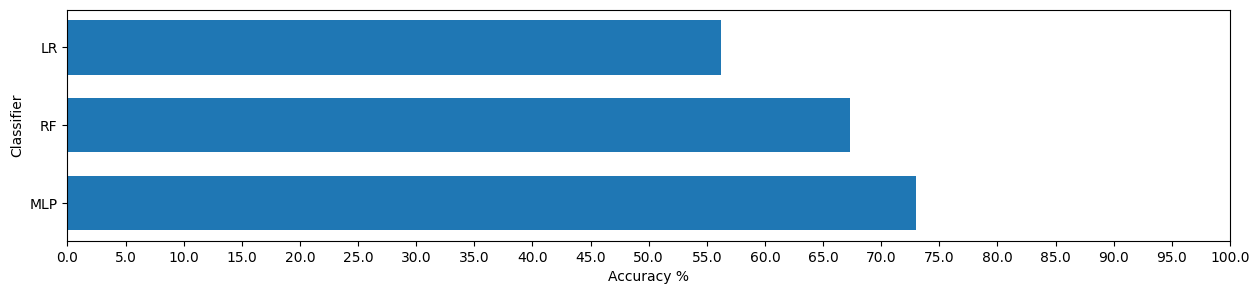

In [ ]:
plt.figure(figsize=(15,3))
plt.barh(range(3), [mlp_score, rf_score, lr_score], height=0.7)
plt.xlim(0, 1)
plt.yticks(range(3), ['MLP', 'RF', 'LR'])
plt.xticks(np.linspace(0, 1, 21), np.linspace(0, 100, 21))

plt.ylabel('Classifier')
plt.xlabel('Accuracy %')
plt.show()

Here we discusses the performance comparison of four powerful machine learning algorithms namely Random Forest, Logistic Regression, and MLP. The results show that MLP is performing the best among these algorithms, with a validation accuracy of 76% and test accuracy of 73%. This is impressive considering that there are 10 different plant types for classification.

After MLP, Random Forest is the second-best performing algorithm with a testing accuracy of 67%. Although Logistic Regression is the fastest and can predict each class out of 10 with %56 accuracy, it is not performing as well as MLP and Random Forest.

However, as the input for this project is in the form of images, the best classifier would be a CNN architecture. CNN can result in even better accuracy than MLP for this project because it is not fully connected, which can result in a lower chance of overfitting.

Moreover, CNN architecture derives features from the image by learning the kernels passed through the image, which has a higher theoretical and experimental guarantee for improved test accuracy results. Therefore, for image classification projects, CNN is a highly recommended algorithm due to its ability to extract features and produce highly accurate results.